In [3]:
#pip install tensorflow

In [4]:
#pip install keras

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import yfinance as yf
from datetime import datetime
import pandas as pd
import psycopg2
import configparser
import datetime
import nbimporter
from Connection_to_pgAdmin4 import *
from SQL import *
from AWS_PostgreSQL import *

In [7]:
# Function to fetch financial information for the last 3 months from the database.
def fetch_financial_info():
    # SQL query to select data from the last 3 months, ordered by Date and Symbol.
    query = """
    SELECT Date, Symbol, Open, High, Low, Close, Volume
    FROM di_financial_info
    WHERE Date > CURRENT_DATE - INTERVAL '3 months'
    ORDER BY Date DESC, Symbol
    """
    
    # Execute the SQL query and store the result.
    financial_data = execute_sql_query_AWS_postgreSQL(query)
    
    # Check if the query returned any data.
    if financial_data:
        # Define column names for the pandas DataFrame.
        columns = ['Date', 'Symbol', 'Open', 'High', 'Low', 'Close', 'Volume']
        
        # Create a pandas DataFrame with the financial data.
        df = pd.DataFrame(financial_data, columns=columns)
        
        # Print the count of NaN values in each column.
        print(df.isnull().sum())  
        
        # Fill NaN values with zero. Alternative handling could be to use the mean.
        df.fillna(0, inplace=True)
        
        # Return the DataFrame with financial data.
        return df
    else:
        # Return None if no data was found.
        return None



In [8]:
# Function to preprocess financial data along with symbols and dates for LSTM model input.
# Window Size 30
def preprocess_data_with_symbols(df, seq_length=30):
    # Initialise a MinMaxScaler to scale features between 0 and 1.
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Get unique symbols from the DataFrame.
    symbols = df['Symbol'].unique()
    
    # Lists to store processed sequences, their corresponding symbols, and dates.
    processed_data = []
    sequence_symbols = []  # Keeps track of symbols for each processed sequence.
    sequence_dates = []  # Keeps track of the date for the last data point in each sequence.
    
    # Iterate over each symbol to process data symbol-wise.
    for symbol in symbols:
        # Create a copy of the DataFrame filtered by current symbol and sort it by date.
        data_symbol = df[df['Symbol'] == symbol].copy()
        data_symbol.sort_values(by='Date', inplace=True)
        
        # Scale the features (Open, High, Low, Close, Volume) for the current symbol.
        scaled_features = scaler.fit_transform(data_symbol[['Open', 'High', 'Low', 'Close', 'Volume']])
        
        # Generate sequences of length 'seq_length' for LSTM input.
        for i in range(len(scaled_features) - seq_length):
            # Each sequence contains 'seq_length' consecutive days of data.
            seq = scaled_features[i:i + seq_length + 1]
            processed_data.append(seq)
            sequence_symbols.append(symbol)  # Associate the current symbol with the sequence.
            # Associate the date of the last data point in the sequence.
            sequence_dates.append(data_symbol.iloc[i + seq_length - 1]['Date'])
            
    # Return the processed sequences, scaler, symbols, and dates as a tuple.
    return np.array(processed_data), scaler, sequence_symbols, sequence_dates



In [9]:
# Defines a function to build an LSTM model with a specified input shape.

def build_model(input_shape):
    # Initialises a Sequential model.
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),  # First LSTM layer with 50 units, returns sequences for further layers.
        LSTM(50),  # Second LSTM layer with 50 units.
        Dense(5)  # Dense layer with 5 units for output, matching the number of predicted features.
    ])
    
    # Compiles the model with the Adam optimizer and mean squared error loss function.
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Returns the compiled model.
    return model


In [10]:
# Main function to execute the model pipeline.
def main():
    # Fetch financial information from the database for the last 3 months.
    df = fetch_financial_info()
    
    # Check if the DataFrame is not empty.
    if df is not None:
        # Preprocess the data to prepare sequences for LSTM model training.
        
        # This includes scaling of features and associating symbols and dates with each sequence.
        processed_data, scaler, sequence_symbols, sequence_dates = preprocess_data_with_symbols(df)
        
        # Shuffle the sequences to randomize the order before splitting into training and testing sets.
        # This step helps in generalizing the model by training on a random sample of sequences.
        indices = np.arange(processed_data.shape[0])
        np.random.shuffle(indices)
        processed_data = processed_data[indices]
        sequence_symbols = np.array(sequence_symbols)[indices]
        sequence_dates = np.array(sequence_dates)[indices]  # Matching dates are shuffled similarly to maintain alignment.
        
        # Split the data into training and testing sets, maintaining an 80-20 split.
        train_size = int(len(processed_data) * 0.8)
        X_train, y_train = processed_data[:train_size, :-1], processed_data[:train_size, -1][:, :5]
        X_test, y_test = processed_data[train_size:, :-1], processed_data[train_size:, -1][:, :5]
        # Extract symbols and dates for the test set to correlate predictions with specific symbols and dates.
        test_symbols = sequence_symbols[train_size:]
        test_dates = sequence_dates[train_size:]
        
        # Initialize and train the LSTM model on the training set.
        model = build_model((X_train.shape[1], X_train.shape[2]))
        history = model.fit(X_train, y_train, epochs=20, batch_size=30, validation_split=0.1, verbose=1)
        
        # Evaluate the model's performance on the test set.
        loss = model.evaluate(X_test, y_test, verbose=1)
        
        # Generate predictions for the test set using the trained model.
        predictions = model.predict(X_test)
        
        # Save model 
        model.save('PredictiveModel6_30days_AWS_postgreSQL_sequense.h5')

        
        # Return a dictionary containing the test set, predictions, model information, and associated symbols and dates.
        # This comprehensive return structure allows for detailed analysis and further processing of the model's predictions.
        return {
            "X_test": X_test,  # Input features for the test set
            "y_test": y_test,  # True output values for the test set
            "predictions": predictions,  # Predicted output values by the model
            "scaler": scaler,  # Scaler object for inverse transformation of predictions
            "model": model,  # Trained LSTM model
            "history": history,  # Training history for analysis
            "loss": loss,  # Loss on the test set for evaluation
            "test_symbols": test_symbols,  # Symbols associated with the test set
            "test_dates": test_dates  # Dates associated with the test set predictions
        }
    else:
        # If no financial data is found, print a message and return None.
        print("No financial data found for the given period.")
        return None


In [11]:
results = main()

Date       0
Symbol     0
Open      41
High      41
Low       41
Close     41
Volume     0
dtype: int64


C:\Users\agd986\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
4046/4046 ━━━━━━━━━━━━━━━━━━━━ 69s 15ms/step - loss: 0.0248 - val_loss: 0.0147
Epoch 2/20
4046/4046 ━━━━━━━━━━━━━━━━━━━━ 61s 15ms/step - loss: 0.0151 - val_loss: 0.0147
Epoch 3/20
4046/4046 ━━━━━━━━━━━━━━━━━━━━ 61s 15ms/step - loss: 0.0147 - val_loss: 0.0144
Epoch 4/20
4046/4046 ━━━━━━━━━━━━━━━━━━━━ 63s 16ms/step - loss: 0.0147 - val_loss: 0.0143
Epoch 5/20
4046/4046 ━━━━━━━━━━━━━━━━━━━━ 61s 15ms/step - loss: 0.0145 - val_loss: 0.0141
Epoch 6/20
4046/4046 ━━━━━━━━━━━━━━━━━━━━ 60s 15ms/step - loss: 0.0143 - val_loss: 0.0142
Epoch 7/20
4046/4046 ━━━━━━━━━━━━━━━━━━━━ 61s 15ms/step - loss: 0.0141 - val_loss: 0.0139
Epoch 8/20
4046/4046 ━━━━━━━━━━━━━━━━━━━━ 61s 15ms/step - loss: 0.0141 - val_loss: 0.0139
Epoch 9/20
4046/4046 ━━━━━━━━━━━━━━━━━━━━ 62s 15ms/step - loss: 0.0137 - val_loss: 0.0136
Epoch 10/20
4046/4046 ━━━━━━━━━━━━━━━━━━━━ 62s 15ms/step - loss: 0.0136 - val_loss: 0.0135
Epoch 11/20
4046/4046 ━━━━━━━━━━━━━━━━━━━━ 62s 15ms/step - loss: 0.0133 - val_loss: 0.0134
Epoch 12

In [13]:
if results:
    # Inverse transform the predictions and true values to their original scale
    predictions_inverse = results['scaler'].inverse_transform(results['predictions'])
    
    y_test_inverse = results['scaler'].inverse_transform(results['y_test'])

    # Print the first few predictions vs. true values for comparison
    print("Predictions vs. True Values:")
    for i in range(10):  # Adjust the range as needed
        print(f"Prediction {i+1}: {predictions_inverse[i]}, True Value {i+1}: {y_test_inverse[i]}")

Predictions vs. True Values:
Prediction 1: [2.6218231e+01 2.6215885e+01 2.6259081e+01 2.6236399e+01 3.0592609e+05], True Value 1: [2.61952381e+01 2.61641026e+01 2.62216216e+01 2.62216216e+01
 3.05926170e+05]
Prediction 2: [2.6405537e+01 2.6424862e+01 2.6399786e+01 2.6413546e+01 3.0592612e+05], True Value 2: [2.63977414e+01 2.63725671e+01 2.64027570e+01 2.64021387e+01
 3.05926248e+05]
Prediction 3: [2.6475016e+01 2.6566057e+01 2.6474882e+01 2.6518135e+01 3.0592691e+05], True Value 3: [2.64947368e+01 2.65601542e+01 2.65145183e+01 2.65255319e+01
 3.05926898e+05]
Prediction 4: [2.6182980e+01 2.6043095e+01 2.6169834e+01 2.6190477e+01 3.0592606e+05], True Value 4: [2.61876289e+01 2.59920000e+01 2.61000000e+01 2.61360825e+01
 3.05926029e+05]
Prediction 5: [2.5656483e+01 2.5733509e+01 2.5636683e+01 2.5630245e+01 3.0592609e+05], True Value 5: [2.56714286e+01 2.56536655e+01 2.56000000e+01 2.56875000e+01
 3.05926108e+05]
Prediction 6: [2.6295471e+01 2.6296482e+01 2.6311728e+01 2.6260311e+01 3.059

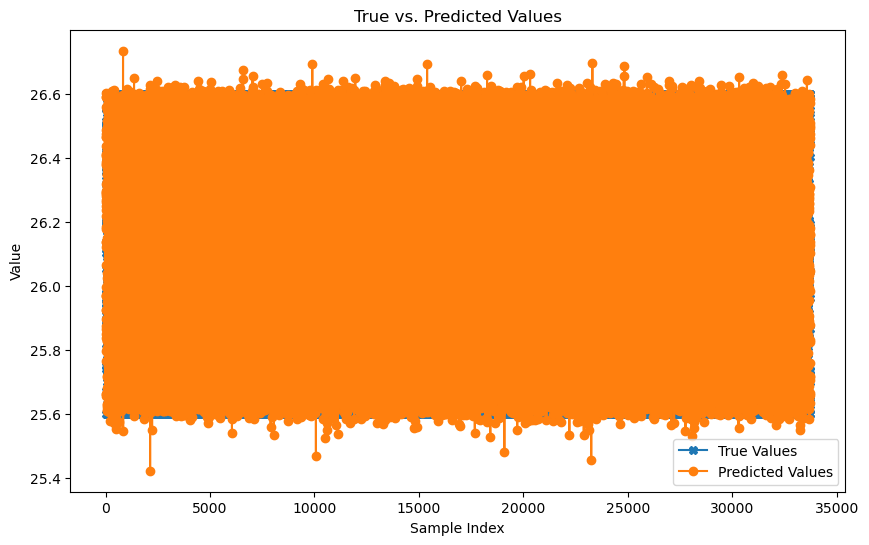

In [14]:
import matplotlib.pyplot as plt

# Check if the results from the model are available.
if results:
    # Initialise a new figure for plotting with dimensions 10x6 inches.
    plt.figure(figsize=(10, 6))
    
    # Plot the true values for the first feature across all samples in the test set,
    # marking each point with an 'X'.
    plt.plot(y_test_inverse[:, 0], label='True Values', marker='X')  # The first feature is selected with [:, 0].
    
    # Plot the predicted values for the same feature, using circles ('o') to mark each predicted point.
    plt.plot(predictions_inverse[:, 0], label='Predicted Values', marker='o')  # Likewise, focusing on the first feature.
    
    # Set the title of the plot to indicate it's comparing true values against predicted ones.
    plt.title('True vs. Predicted Values')
    
    # Label the x-axis as 'Sample Index' to indicate the position of each sample in the dataset.
    plt.xlabel('Sample Index')
    
    # Label the y-axis as 'Value' to denote the value of the feature being plotted.
    plt.ylabel('Value')
    
    # Add a legend to the plot to distinguish between true and predicted values visually.
    plt.legend()
    
    # Display the plot.
    plt.show()


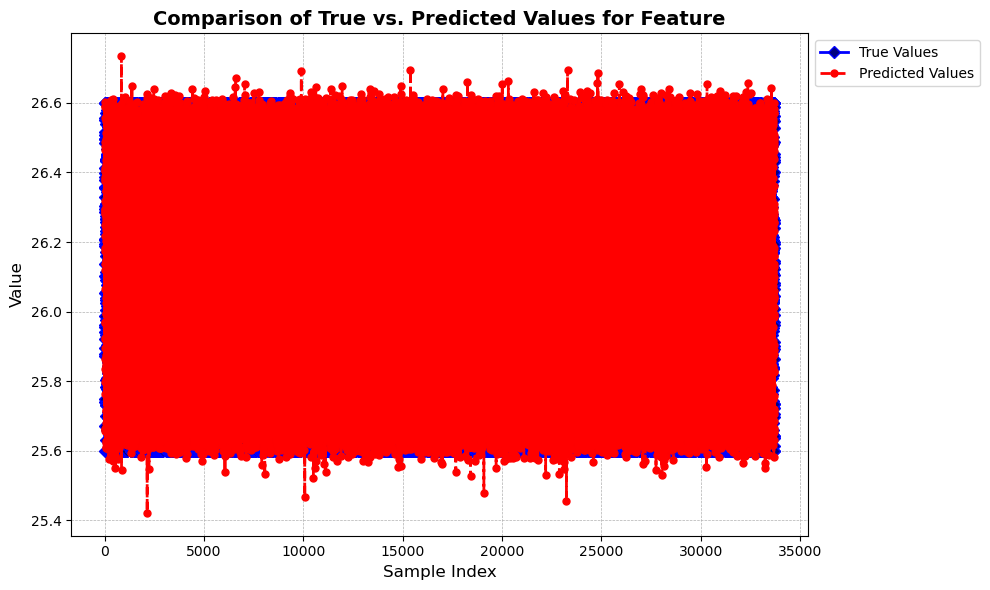

In [15]:
#Second Visualisation 

if results:
    # Initialise a figure for plotting with dimensions 10x6 inches for better visibility.
    plt.figure(figsize=(10, 6))
    
    # Plot the true values with a solid blue line and diamond markers.
    plt.plot(y_test_inverse[:, 0], 'b-',
             label='True Values', linewidth=2, marker='D', markersize=6, markerfacecolor='navy')
    
    # Plot the predicted values with a dashed orange line and circle markers.
    plt.plot(predictions_inverse[:, 0], 'r--',
             label='Predicted Values', linewidth=2, marker='o', markersize=5, markerfacecolor='red')
    
    # Set a more descriptive title to provide context.
    plt.title('Comparison of True vs. Predicted Values for Feature', fontsize=14, fontweight='bold')
    
    # Label axes with more detail.
    plt.xlabel('Sample Index', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    
    # Add a grid to the background for better readability.
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Add a legend with an optimal position outside the plot area.
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # Adjust layout to make room for the legend.
    plt.tight_layout()
    
    # Display the enhanced plot.
    plt.show()

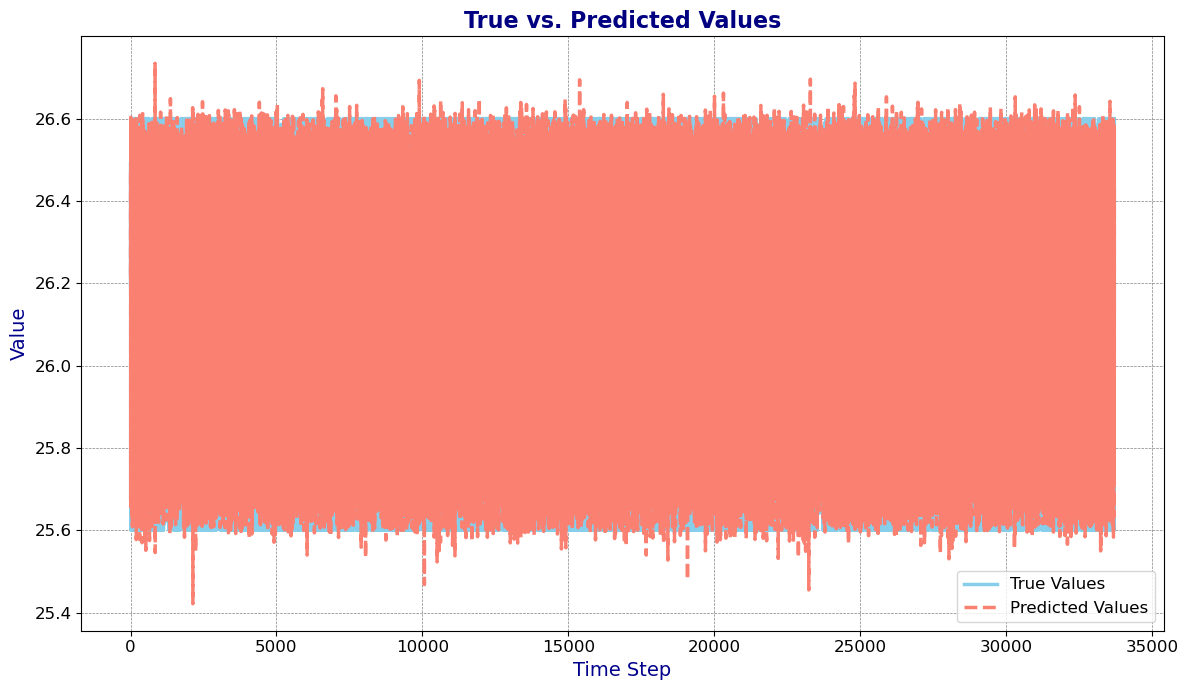

In [16]:
#Third Visualisation

if results:
    # Initialize the plot with a specific size for better visibility
    plt.figure(figsize=(12, 7))

    # Plot the true values using a solid line
    plt.plot(y_test_inverse[:, 0], label='True Values', color='skyblue', linewidth=2.5, linestyle='-')

    # Plot the predicted values using a different style
    plt.plot(predictions_inverse[:, 0], label='Predicted Values', color='salmon', linewidth=2.5, linestyle='--')

    # Adding some aesthetics to make the chart more readable and visually appealing
    plt.title('True vs. Predicted Values', fontsize=16, fontweight='bold', color='navy')
    plt.xlabel('Time Step', fontsize=14, color='darkblue')
    plt.ylabel('Value', fontsize=14, color='darkblue')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Enable grid for better readability
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='grey')
    
    # Add a legend to help differentiate between true and predicted values
    plt.legend(loc='best', fontsize=12)

    # Ensure everything fits without clipping
    plt.tight_layout()

    # Display the plot
    plt.show()

In [17]:
if results:
    # Update the 'predictions' key in the results dictionary with model predictions on the test set.
    results['predictions'] = results['model'].predict(results['X_test'])
    
    # Apply inverse transformation back to their original scale.
    predictions_inverse = results['scaler'].inverse_transform(results['predictions'])
    y_test_inverse = results['scaler'].inverse_transform(results['y_test'])
    
    # Compile a DataFrame for a side-by-side comparison of true and predicted 'Open' values,
    # including the symbol associated with each prediction.
    comparison_df = pd.DataFrame({
        'Symbol': results['test_symbols'],  # Symbols associated with test data
        'True_Open': y_test_inverse[:, 0],  # True 'Open' values in original scale
        'Predicted_Open': predictions_inverse[:, 0],  # Predicted 'Open' values in original scale
    })
    
    # Display the first 100 rows of the comparison DataFrame for review.
    print(comparison_df.head(25))


1054/1054 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
    Symbol  True_Open  Predicted_Open
0   EEDM.L  26.195238       26.218231
1   0HV2.L  26.397741       26.405537
2   COPG.L  26.494737       26.475016
3    CMH.L  26.187629       26.182980
4   HEAD.L  25.671429       25.656483
5   RTWP.L  26.293750       26.295471
6    FEM.L  25.871903       25.863186
7   0K9P.L  26.600000       26.603189
8   FLRG.L  26.514894       26.465044
9   0KC4.L  26.052588       26.065033
10   EWI.L  26.328571       26.284782
11  0HAL.L  26.102693       26.119520
12  0GRK.L  26.136160       26.137672
13  0K3H.L  26.377720       26.411421
14  CW8U.L  26.497497       26.376406
15   BAR.L  25.600000       25.661352
16  ASHM.L  25.961654       25.923586
17  QQQ3.L  26.483631       26.281313
18  0KG0.L  25.988693       25.970440
19  PRIR.L  26.387781       26.293077
20  VDEV.L  26.303757       26.316851
21  SRSA.L  25.894589       25.796309
22  PRIT.L  25.941317       25.661432
23  MOTR.L  26.357033       26.386786
24  ARB

In [20]:
def insert_predictions(insert_data):
    table_name = "predictive_model6_results_aws_postgresql"
    # Define the SQL insert statement
    insert_query_template = f"""
    INSERT INTO {table_name} (
        Symbol, True_Open, True_High, True_Low, True_Close, True_Volume,
        Predicted_Open, Predicted_High, Predicted_Low, Predicted_Close, Predicted_Volume,
        DateTo)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);
    """
    
    for row in insert_data:
        # Prepare the values for insertion
        values = (
            row["Symbol"],
            row["True_Open"], row["True_High"], row["True_Low"], row["True_Close"], row["True_Volume"],
            row["Predicted_Open"], row["Predicted_High"], row["Predicted_Low"], row["Predicted_Close"], row["Predicted_Volume"],
            row["DateTo"]
        )
        
        # Use the execute_sql_query function to insert the data
        execute_sql_query_AWS_postgreSQL(insert_query_template, values)


In [21]:
if results:
    predictions_inverse = results['scaler'].inverse_transform(results['predictions'])
    y_test_inverse = results['scaler'].inverse_transform(results['y_test'])
    test_symbols = results['test_symbols']
    test_dates = results['test_dates']  # This now holds the prediction dates

    insert_data = []
    for i in range(len(predictions_inverse)):
        # Format test_dates[i] as needed, e.g., to string if it's not already
        prediction_date_str = test_dates[i].strftime('%Y-%m-%d')
        row = {
            "Symbol": test_symbols[i],
            "True_Open": round(float(y_test_inverse[i, 0]), 2),
            "True_High": round(float(y_test_inverse[i, 1]), 2),
            "True_Low": round(float(y_test_inverse[i, 2]), 2),
            "True_Close": round(float(y_test_inverse[i, 3]), 2),
            "True_Volume": round(float(y_test_inverse[i, 4]), 2),
            "Predicted_Open": round(float(predictions_inverse[i, 0]), 2),
            "Predicted_High": round(float(predictions_inverse[i, 1]), 2),
            "Predicted_Low": round(float(predictions_inverse[i, 2]), 2),
            "Predicted_Close": round(float(predictions_inverse[i, 3]), 2),
            "Predicted_Volume": round(float(predictions_inverse[i, 4]), 2),
            "DateTo": prediction_date_str
        }
        insert_data.append(row)

    # Now call insert_predictions with the prepared insert_data
    insert_predictions(insert_data)

